In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import jax
import jax.numpy as jnp
import visualization
from utils import results, experiments,settings, equioutput, evaluation

from numpyro import distributions
import matplotlib.pyplot as plt

In [2]:
result = results.ResultSample.load_from_file(
    "/home/gw/data/experiments/master_thesis/results/{}.tar.gz".format(
        # 1 hl, 3 hn
        #"1cd0fb4d70b0c0c9bc850afe49a45128"
        "cbc8fa72832a535540fd3a72274bd1df"
        #"f542d3ebd37584291a4d8e9cef5b95f7"
        
        # 1 hl, 4 hn
        #"e99343eb8d643d1e9212b2fcab193df5"
        #"24b3fa55b428355bcb56dab1ae496025"
        #"c6835cefcab68b58b6f07158f1137c83"
        
        # 2 hl, 3 hn
        #"6fad5c77c6e4fcd72601720d57bf25fb"
        #"89478192c4d7fb7c0c138a6635f0ff04"
        #"3f20a27ee0828d865a36320f2af66afb"
        
        # 2 hl, 4 hn
        #"5fe59dd56f3ecc657fa49ac8b4ec4dce"
        #"f47e4647c414e39d47e2d5b79a59ce1e"
        #"ee1191f6065b8f88c88a62cffa269857"
        
        # 2 hl, 8hn
        #"37bccc0afc165ff842fbbeab926ab2f3"
        #"2afe0c254c0afa9dd1ba436f4be5affb"
        #"52a86ebd73aaa81538d2dccf80bd1b68"
        
        # 4 hl, 4 hn
        #"1664a41abb8c2042a3a316cefd1c5e87" # regression2d
        
        # 4 hl, 32 hn
        #"38f6050fa91f25710241415d48efd354"
        #"4577b97cdcaf05eeff1baaec7cd3fe4d"
    )
)
experiment = experiments.FactoryExperiment(result.experiment_type, **{"settings": result.settings})()
print(experiment._settings)

normalized probabilities: [0.5665243  0.3504857  0.08298998]
SettingsExperimentSample(output_path='/home/ubuntu/data/experiments/master_thesis/results', dataset='izmailov', dataset_normalization='standardization', hidden_layers=1, hidden_neurons=3, activation='tanh', activation_last_layer='none', num_warmup=1024, statistic='reduced', statistic_p=0.99, samples_per_chain=1, identifiable_modes=3, pool_size=10, seed=0)


In [3]:
def kl_divergence(p_values, q_values):
    assert p_values.shape == q_values.shape
    
    # normalize
    p_values /= p_values.sum()
    q_values /= q_values.sum()
    
    n = len(p_values.flatten())
    return (p_values * (jnp.log(p_values + 1e-6) - jnp.log(q_values + 1e-6))).sum()# / n

In [4]:
# distribution stuff
resolution = 256
x = jnp.linspace(-3.0, 3.0, resolution)[:, jnp.newaxis]
y = jnp.linspace(-3.0, 3.0, resolution)[:, jnp.newaxis]

#jax.scipy.special.logsumexp
#parameters_prior_distribution = experiment._model._parameters_prior(jnp.zeros(sample.shape), jnp.ones(sample.shape))
std = result.samples['std'].mean()

posterior_predictive_history = []
posterior_predictive = jnp.zeros((resolution, resolution))
means_history = []
kl_divergences = []
kl_divergences_parameters = []

n = len(result.samples["parameters"])
for i in range(n):
    sample = result.samples["parameters"][i]
    #std = result.samples["std"][i]
    means = experiment._model_transformation.apply_from_vector(x, sample)
    means_history.append(means)   
    likelihood_distribution = experiment._model._outputs_likelihood(means, jnp.ones_like(means) * std)
    log_likelihood = likelihood_distribution.log_prob(x.squeeze())
    likelihood = jnp.exp(log_likelihood)
    posterior_predictive += likelihood
    posterior_predictive_history.append(posterior_predictive / (i + 1))
    if i > 0:
        # posterior predictive
        tmp_posterior_predictive_before = posterior_predictive_history[-2]
        tmp_posterior_predictive_after = posterior_predictive_history[-1]
        kl_divergences.append(kl_divergence(
            tmp_posterior_predictive_after,
            tmp_posterior_predictive_before
        ).item())
        
        # posterior parameters - THIS REQUIRES FITTING FIRST - MAYBE KDE?
        #kl_divergences_parameters.append(kl_divergence(
        #    result.samples["parameters"][:i + 1],
        #    result.samples["parameters"][:i]
        #).item())

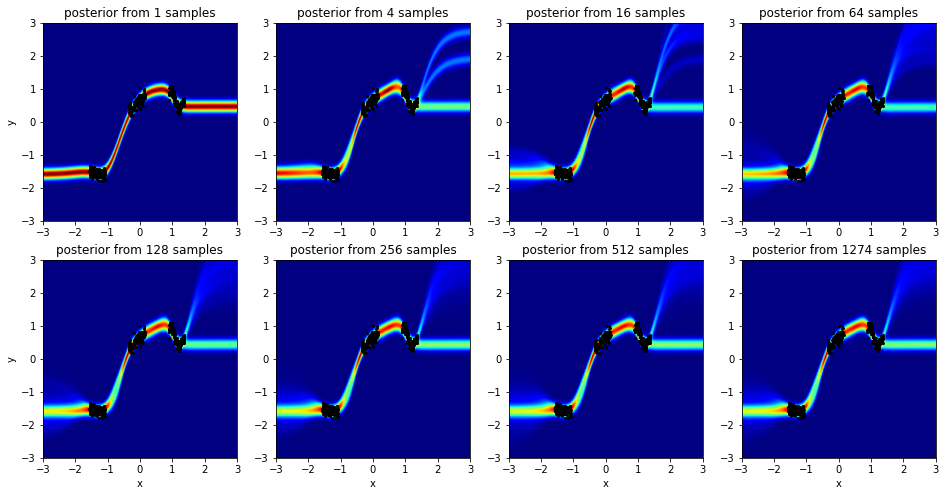

In [31]:
xx, yy = jnp.meshgrid(x.squeeze(), y.squeeze())

indices = [0, 3, 15, 63, 127, 255, 511, n-1]
cols = 4
rows = 2
plots = cols * rows
figure = plt.figure(figsize=(4 * cols, 4 * rows))
for row in range(rows):
    for col in range(cols):
        i = row * cols + col
        #posterior = int(((1.0 * i) / plots) * n)
        posterior = indices[i]
        ax = figure.add_subplot(rows, cols, i + 1)
        ax.set_xlim(-3.0, 3.0)
        ax.set_ylim(-3.0, 3.0)
        ax.set_title(f"posterior from {posterior + 1} samples")
        
        if col == 0:
            ax.set_ylabel("y")
        if row == rows - 1:
            ax.set_xlabel("x")
        maximum, minimum = posterior_predictive_history[posterior].max(), posterior_predictive_history[posterior].min()
        values = 1.0 - (posterior_predictive_history[posterior] - minimum) / (maximum - minimum)
        values = posterior_predictive_history[posterior]
        ax.pcolormesh(xx, yy, (values.T + 1e-6), cmap="jet", shading="gouraud")
        ax.scatter(experiment._dataset.data[:, 0], experiment._dataset.data[:, 1], c="black", s=4)

#for mean in means_history:
#    ax.plot(x, mean, c="blue", alpha=0.01)

In [6]:
figure.savefig("posterior_predictive.png", dpi=96)

In [7]:
total_kl_divergences = []
for pp in posterior_predictive_history:
    total_kl_divergences.append(kl_divergence(
        posterior_predictive_history[-1],
        pp
    ))

In [8]:
print(jnp.log(jnp.array(total_kl_divergences) + 1e-6))

[ -0.89813364  -1.6528251   -1.8234135  ... -11.705676   -12.382652
 -13.815511  ]


Text(0, 0.5, 'log')

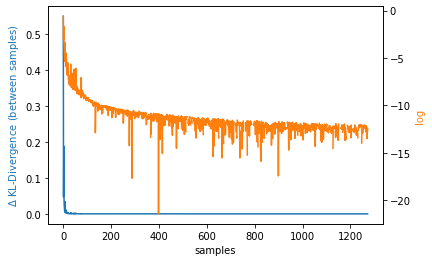

In [9]:
figure = plt.figure()
ax1 = figure.add_subplot(1, 1, 1)
ax1.plot(jnp.arange(n-1), jnp.array(kl_divergences)[:n], color="tab:blue")
ax1.set_xlabel("samples")
ax1.set_ylabel(r"$\Delta$ KL-Divergence (between samples)", color="tab:blue")

ax2 = ax1.twinx()
ax2.plot(jnp.arange(n-1), jnp.log(jnp.array(kl_divergences)), color="tab:orange")
ax2.set_ylabel(r"log", color="tab:orange")

In [10]:
figure.savefig("kl_delta.png", dpi=96)

Text(0, 0.5, 'log')

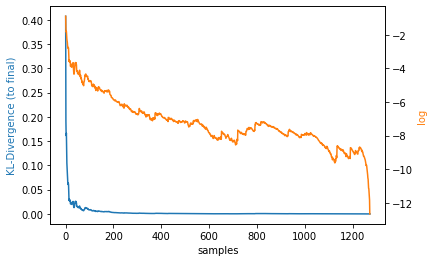

In [11]:
figure = plt.figure()
ax1 = figure.add_subplot(1, 1, 1)
ax1.plot(jnp.arange(len(total_kl_divergences)), (jnp.array(total_kl_divergences)), c="tab:blue")
ax1.set_xlabel("samples")
ax1.set_ylabel(r"KL-Divergence (to final)", color="tab:blue")

ax2 = ax1.twinx()
ax2.plot(jnp.arange(len(total_kl_divergences)), jnp.log(jnp.array(total_kl_divergences)), color="tab:orange")
ax2.set_ylabel(r"log", color="tab:orange")

In [12]:
figure.savefig("kl_total.png", dpi=96)